In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [1]:
import pandas as pd
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import clip
import cv2
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.8.1+cu111


In [2]:
meme_df = pd.read_csv('memes.csv', names=['meme_id', 'file_id', 'author_id', 'timestamp', 
                                        'filetype', 'unique_id', 'caption' ], header=None)

In [3]:
meme_df.head()

,meme_id,file_id,author_id,timestamp,filetype,unique_id,caption
0,2811,AgACAgQAAxkBAAJJWGHqZIz4f3WSyvH0XIFxhvPjwqWxAA...,2106431824,2022-01-21 07:45:16.000000,photo,NaN,NaN
1,2826,AgACAgIAAxkBAAKIG2H3n_djkRg9MMUShOzCMHRcIm6mAA...,354637850,2022-01-31 08:38:15.000000,photo,AQADfL0xG4l3uUt9,NaN
2,2827,AgACAgQAAxkBAAL2pGIEAAH2wjbF8DWHGiNewBn_UnrE6A...,354637850,2022-02-09 17:59:18.000000,photo,AQADyqoxGw8rrVF-,NaN
3,2876,AgACAgQAAxkBAAL-aWIEBLnt94wyXCXhygRdYajavWbvAA...,2106431824,2022-02-09 18:15:21.000000,photo,AQADBqsxG3SVDFB-,"kvin, where is your corona"
4,2925,AgACAgQAAxkBAAEBAiBiBAetqQPwhJcXSKpCGXgI4lgbIw...,2106431824,2022-02-09 18:27:57.000000,photo,AQADUa0xGzmh5VJ9,Why do you keep coming back?


In [4]:
class MemeDataset:
    def __init__(self, image_paths, augmentations=None):
        self.image_paths = image_paths
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = torch.tensor(np.array(image))
        
        if self.augmentations is not None:
            image = self.augmentations(image)
            
#         image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        image_id = self.image_paths[item].split('/')[-1].split('.')[0]
        
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "image_id": image_id
        }
    

## Use ViT-B/32 as feature extractor

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x1553e50447b8>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [7]:
data_folder = './memes_pic/'
image_paths = [data_folder + file for file in os.listdir(data_folder)] 

good_image_paths = []

for image_path in image_paths:
    try:
        Image.open(image_path).convert("RGB")
        good_image_paths.append(image_path)
    except:
        pass

In [8]:
from torchvision import datasets, transforms

transform=transforms.Compose([
                         transforms.Scale(224),
                         transforms.CenterCrop(224),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                              std=[0.26862954, 0.26130258, 0.27577711]),
                                 ])

dataset = MemeDataset(
    image_paths=good_image_paths,
    augmentations=transform
)

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=16)

In [9]:
description_list = ['funny', 'person', 'cat', 'dog', 'text', 'meme', 
                    'offensive', 'witty', 'cringe', 'people', 'anime',
                   'animated', 'emotional', 'cute', 'auto']


text_tokens = clip.tokenize([f"This is {desc} image" for desc in description_list]).cuda()

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [10]:
good_image_ids = [path.split('/')[-1].split('.')[0] for path in good_image_paths]
meme_feat_df = meme_df[meme_df.file_id.isin(good_image_ids)]

In [11]:
feat_list = [description + '_score' for description in description_list]
meme_feat_df[feat_list] = 1.

In [12]:

for idx, batch in enumerate(dataloader):
    image_ids = batch['image_id']
    with torch.no_grad():
        image_features = model.encode_image(batch['image'].cuda()).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
#     print(similarity.shape)
    for i, image_id in enumerate(image_ids):
        meme_feat_df.loc[meme_feat_df.file_id == image_id, feat_list] = similarity.T[i]

In [13]:
meme_feat_df.to_csv('memes_wclip_feats.csv', index = False)

In [14]:
meme_feat_df.head()

,meme_id,file_id,author_id,timestamp,filetype,unique_id,caption,funny_score,person_score,cat_score,...,meme_score,offensive_score,witty_score,cringe_score,people_score,anime_score,animated_score,emotional_score,cute_score,auto_score
0,2811,AgACAgQAAxkBAAJJWGHqZIz4f3WSyvH0XIFxhvPjwqWxAA...,2106431824,2022-01-21 07:45:16.000000,photo,NaN,NaN,0.250981,0.237676,0.217957,...,0.251079,0.213471,0.224981,0.229358,0.248814,0.223537,0.231514,0.252318,0.233501,0.249587
1,2826,AgACAgIAAxkBAAKIG2H3n_djkRg9MMUShOzCMHRcIm6mAA...,354637850,2022-01-31 08:38:15.000000,photo,AQADfL0xG4l3uUt9,NaN,0.264385,0.252193,0.220355,...,0.264848,0.243699,0.242989,0.242963,0.261154,0.244021,0.254006,0.247862,0.243598,0.252435
2,2827,AgACAgQAAxkBAAL2pGIEAAH2wjbF8DWHGiNewBn_UnrE6A...,354637850,2022-02-09 17:59:18.000000,photo,AQADyqoxGw8rrVF-,NaN,0.245900,0.212461,0.197702,...,0.239926,0.232262,0.242150,0.253753,0.212315,0.221327,0.222178,0.244417,0.230103,0.235808
3,2876,AgACAgQAAxkBAAL-aWIEBLnt94wyXCXhygRdYajavWbvAA...,2106431824,2022-02-09 18:15:21.000000,photo,AQADBqsxG3SVDFB-,"kvin, where is your corona",0.238833,0.237176,0.200625,...,0.240958,0.237480,0.239432,0.234064,0.240731,0.216932,0.225121,0.210288,0.224446,0.238979
4,2925,AgACAgQAAxkBAAEBAiBiBAetqQPwhJcXSKpCGXgI4lgbIw...,2106431824,2022-02-09 18:27:57.000000,photo,AQADUa0xGzmh5VJ9,Why do you keep coming back?,0.242307,0.206670,0.173449,...,0.245140,0.239347,0.234380,0.240613,0.207647,0.213957,0.219453,0.223919,0.223322,0.228427


## Visualize memes with highes scores

In [16]:
meme_feat_df[feat_list[0]].max()

0.28519314527511597

In [26]:
feat_list

['funny_score',
 'person_score',
 'cat_score',
 'dog_score',
 'text_score',
 'meme_score',
 'offensive_score',
 'witty_score',
 'cringe_score',
 'people_score',
 'anime_score',
 'animated_score',
 'emotional_score',
 'cute_score',
 'auto_score']

In [80]:
feat_list_to_plot = ['funny_score', 'cat_score', 'dog_score', 
                     'meme_score', 'cringe_score', 'cute_score']

best_match_dict = {}
for clip_feat in feat_list_to_plot:
    value = (meme_feat_df.loc[meme_feat_df[clip_feat] == meme_feat_df[clip_feat].max(), 'file_id'].values[0],
             meme_feat_df.loc[meme_feat_df[clip_feat] == meme_feat_df[clip_feat].min(), 'file_id'].values[0])
    best_match_dict[clip_feat] = value

In [81]:
max_score_list = [Image.open(data_folder + value[0] + '.png').convert("RGB") for key, value in best_match_dict.items()]

In [100]:
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os

def display_images(
    images, titles,
    columns=3, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(titles[i].split('_')[0], fontsize=label_font_size);

#         if hasattr(image, 'filename'):
#             title=image.filename
#             if title.endswith("/"): title = title[0:-1]
#             title=os.path.basename(title)
#             title=textwrap.wrap(title, label_wrap_length)
#             title="\n".join(title)
#             plt.title(title, fontsize=label_font_size); 

In [101]:
max_score_list = [Image.open(data_folder + value[0] + '.png').convert("RGB") for key, value in best_match_dict.items()]

In [102]:
len(max_score_list)

6

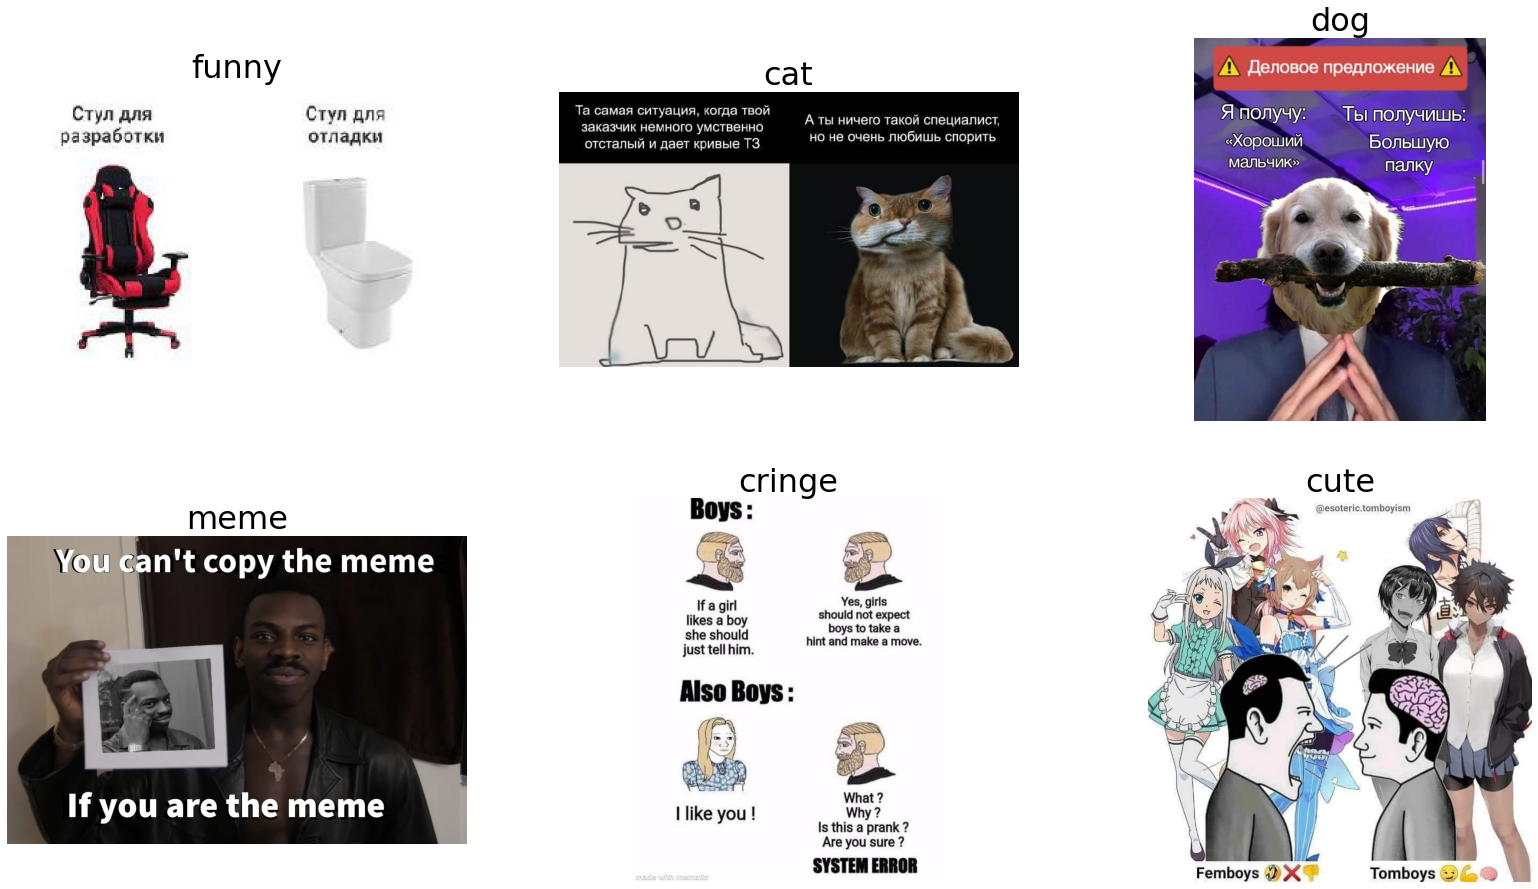

In [109]:
display_images(
    max_score_list, feat_list_to_plot,
    columns=3, width=28, height=12, max_images=15, 
    label_wrap_length=50, label_font_size=32)

plt.savefig('top_meme_scores.jpg', dpi=600, bbox_inches='tight')